In [45]:

import pandas as pd
import torch

data_folder = "../data/interm/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [46]:
users = pd.read_csv(data_folder + "users.csv")
items = pd.read_csv(data_folder + "items.csv")
ratings = pd.read_csv(data_folder + "ratings.csv")
genres = pd.read_csv("../data/raw/ml-100k/u.genre", delimiter="|", names=["name", "index"])

In [47]:
ratings

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [48]:
import numpy as np


def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('user_id')['rating'].count()
    
    unique_users = ratings.user_id.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.user_id.map(user_to_index)
    
    unique_movies = ratings.item_id.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.item_id.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [49]:
(n, m), (X, y), (user_to_index, movie_to_index) = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 943 users, 1682 movies
Dataset shape: (100000, 2)
Target shape: (100000,)


In [50]:
import math


class ReviewsIterator:
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [51]:

def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)
     


In [52]:
from itertools import zip_longest
from torch import nn


class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.
        n_movies: 
            Number of unique movies in the dataset.
        n_factors: 
            Number of columns in the embeddings matrix.
        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.
        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).
        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [53]:

from torch.optim.lr_scheduler import _LRScheduler


class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]
     

In [54]:

def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler
     

In [55]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler
     

In [56]:

from matplotlib import pyplot as plt


def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

In [57]:

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [58]:

net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [186]:
print(net)

EmbeddingNet(
  (u): Embedding(943, 150)
  (m): Embedding(1682, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


In [59]:
minmax = float(ratings.rating.min()), float(ratings.rating.max())
minmax

(1.0, 5.0)

In [60]:
from torch import optim

lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [61]:
import copy

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False

        running_loss = 0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            #print(x_batch[:,0])
          
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

c:\users\esire\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss improvement on epoch: 1
[001/100] train: 1.1590 - val: 1.0022
loss improvement on epoch: 2
[002/100] train: 0.9194 - val: 0.9357
loss improvement on epoch: 3
[003/100] train: 0.8839 - val: 0.9041
loss improvement on epoch: 4
[004/100] train: 0.8427 - val: 0.9018
loss improvement on epoch: 5
[005/100] train: 0.8461 - val: 0.8958
loss improvement on epoch: 6
[006/100] train: 0.8134 - val: 0.8909
loss improvement on epoch: 7
[007/100] train: 0.8249 - val: 0.8836
[008/100] train: 0.7941 - val: 0.8914
[009/100] train: 0.8018 - val: 0.8936
[010/100] train: 0.7721 - val: 0.8902
[011/100] train: 0.7755 - val: 0.8984
[012/100] train: 0.7318 - val: 0.9052
[013/100] train: 0.7293 - val: 0.9110
[014/100] train: 0.6709 - val: 0.9203
[015/100] train: 0.6725 - val: 0.9294
[016/100] train: 0.6104 - val: 0.9417
[017/100] train: 0.6118 - val: 0.9582
early stopping after epoch 017


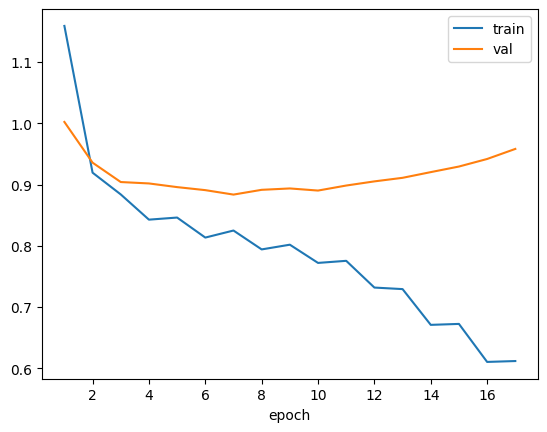

In [62]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

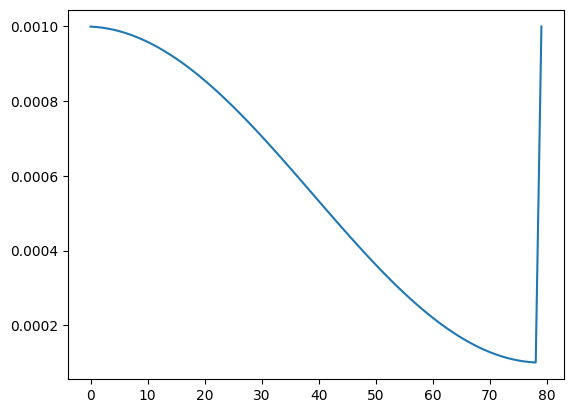

In [63]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [64]:

groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [65]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.9787


In [66]:
ratings

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [73]:
users

,user_id,age,zip_code,male,female,occupation_technician,occupation_other,occupation_writer,occupation_executive,occupation_administrator,...,occupation_librarian,occupation_homemaker,occupation_artist,occupation_engineer,occupation_marketing,occupation_none,occupation_healthcare,occupation_retired,occupation_salesman,occupation_doctor
0,1,24,85711,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,53,94043,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,23,32067,True,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,24,43537,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,33,15213,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,26,33319,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
939,940,32,02215,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
940,941,20,97229,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
941,942,48,78209,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [71]:
items

,movie_id,movie_title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995.0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995.0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995.0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1998.0
1678,1679,B. Monkey (1998),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1998.0
1679,1680,Sliding Doors (1998),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1998.0
1680,1681,You So Crazy (1994),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1994.0


In [145]:
def predict_rating(user_id, movie_ids):
    return net(torch.tensor([user_to_index[user_id] for _ in movie_ids]).to("cuda"), torch.tensor([movie_to_index[movie_id] for movie_id in movie_ids]).to("cuda"), minmax)


In [146]:
predict_rating(1, [2])

tensor([[3.2065]], device='cuda:0', grad_fn=<SubBackward0>)

In [147]:
def get_movie_ids_already_rated(user_id):
    users_ratings = ratings[ratings["user_id"] == user_id]
    return users_ratings["item_id"].unique()

In [178]:
def recommendations_for(user_id):
    item_ids = items["movie_id"]
    already_rated_items: np.ndarray = get_movie_ids_already_rated(user_id)
    items_to_rate = []
    for item_id in item_ids:
        if not np.any(already_rated_items == item_id):
            items_to_rate.append(item_id)
    predicted_ratings: torch.Tensor = predict_rating(user_id, items_to_rate)
    indices = torch.nonzero(predicted_ratings >= 4.5)[:, 0]
    return [(items_to_rate[i], predicted_ratings[i].item()) for i in indices]

In [185]:
recs = recommendations_for(14)
recs.sort(key=lambda x: x[1], reverse=True)
for item_id, rating in recs[:10]:
    title = items[items["movie_id"] == item_id]["movie_title"].item()
    print(title, rating)

Santa with Muscles (1996) 4.933708667755127
Shawshank Redemption, The (1994) 4.785585403442383
Paths of Glory (1957) 4.7398905754089355
Bitter Sugar (Azucar Amargo) (1996) 4.691195487976074
M (1931) 4.689870357513428
Month by the Lake, A (1995) 4.67845344543457
North by Northwest (1959) 4.664621353149414
Lost Horizon (1937) 4.647344589233398
Caro Diario (Dear Diary) (1994) 4.6183013916015625
Butcher Boy, The (1998) 4.613495826721191
